In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.inspection import permutation_importance

Load data

In [21]:
df = pd.read_csv("data/mammographic.csv", header=None)
df.columns = ["feat_1", "feat_2", "feat_3", "feat_4", "feat_5", "class"]
df.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,class
0,0.090909,0.628205,0.666667,1.00,0.666667,1.0
1,0.090909,0.512821,1.000000,1.00,0.666667,1.0
2,0.072727,0.128205,0.000000,0.00,0.666667,0.0
3,0.090909,0.500000,0.000000,1.00,0.666667,1.0
4,0.090909,0.743590,0.000000,0.75,0.666667,1.0


In [22]:
df["class"].value_counts()

0.0    427
1.0    403
Name: class, dtype: int64

In [50]:
A = df.drop(columns=["class"])
b = df.loc[:, "class"]
A.shape, b.shape

((830, 5), (830,))

Neural Network

In [51]:
X = torch.tensor(A.values, dtype=torch.float32)
y = torch.tensor(b, dtype=torch.float32).reshape(-1, 1)

In [25]:
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(5, 5)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(5, 5)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(5, 5)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(5, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [26]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        print(epoch, end=" ")
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
model = Deep()
acc = model_train(model, X_train , y_train, X_test, y_test)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 

In [44]:
from torchmetrics.classification import BinaryF1Score, BinaryAUROC
from torcheval.metrics.aggregation.auc import AUC
preds = model(X)
print(round(acc, 4))
metric = BinaryF1Score()
print(metric(preds, y))
metric = BinaryAUROC(thresholds=None)
print(metric(preds, y))

0.8112
tensor(0.8109)
tensor(0.8450)


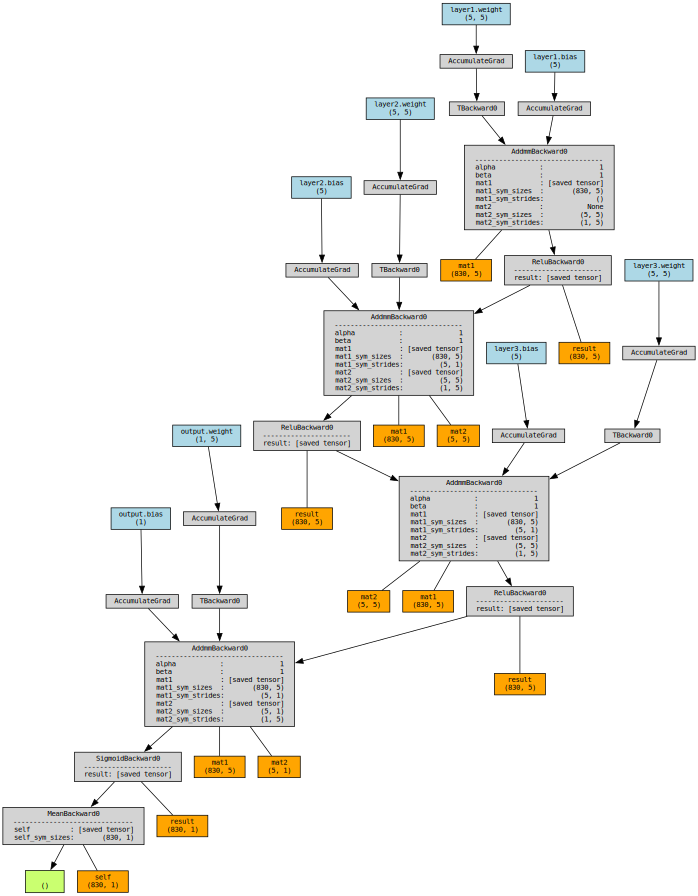

In [45]:
from torchviz import make_dot
make_dot(preds.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [57]:
import shap

c:\Users\Patryk\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



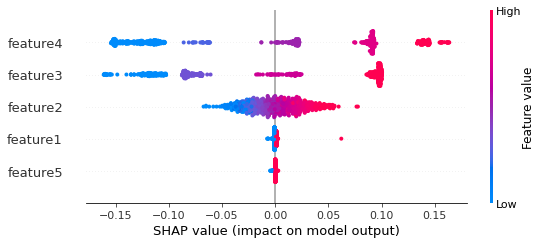

In [58]:
explainer = shap.DeepExplainer(model, X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names=["feature1", "feature2", "feature3", "feature4", "feature5"])